# Stock Price Prediction using Random forest regression.


Importing all libraries required for stock price predicition.

In [61]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels as smt

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

This notebook contains series of codeblocks for predicting  "DISNEY", "AMAZON" and "GOOGLE" stock prices.

In [62]:
stock = ['DIS','AMZN','GOOG']

As a first step, usig pandas_datareader we are fetching time series data of above mentioned three stocks and storing it in a stocks dictionary

In [63]:
stocks = {}
for i in stock:
    start = datetime.datetime(2010, 1, 1)
    end = datetime.datetime(2021, 2, 13)
    stocks[i] = web.DataReader(i, 'yahoo', start, end)

Time Series Exploratory Data Analysis (EDA)

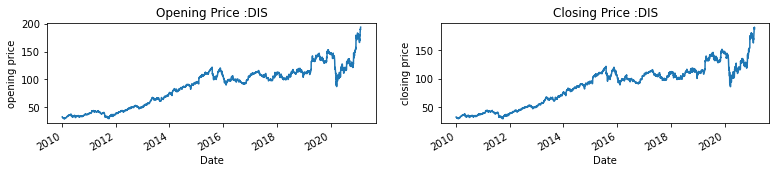

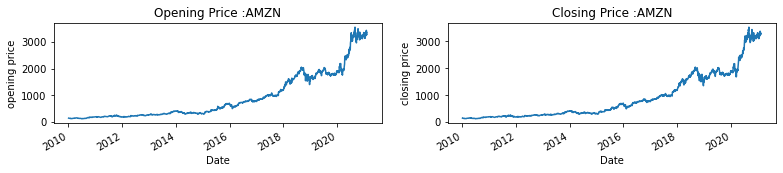

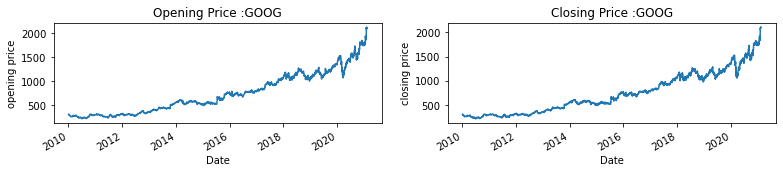

In [64]:
for i in stock:
    #open price
    fig = plt.figure(figsize=(20, 7))
    openPrice_plt = plt.subplot2grid((3, 3), (1,0))
    high = stocks[i]['High']
    high.grid = True
    openPrice_plt.set_title('Opening Price :' + i)
    openPrice_plt.set_xlabel('years')
    openPrice_plt.set_ylabel('opening price')
    high.plot(ax=openPrice_plt)
    #close price
    closePrice_plt = plt.subplot2grid((3, 3), (1,1))
    close = stocks[i]['Close']
    close.grid = True
    closePrice_plt.set_title('Closing Price :' + i)
    closePrice_plt.set_xlabel('years')
    closePrice_plt.set_ylabel('closing price')
    
    close.plot(ax=closePrice_plt)
    
    returns = np.diff(close)
    #correlation
    high.corr(close)

In [65]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
   

In [66]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

In [67]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)


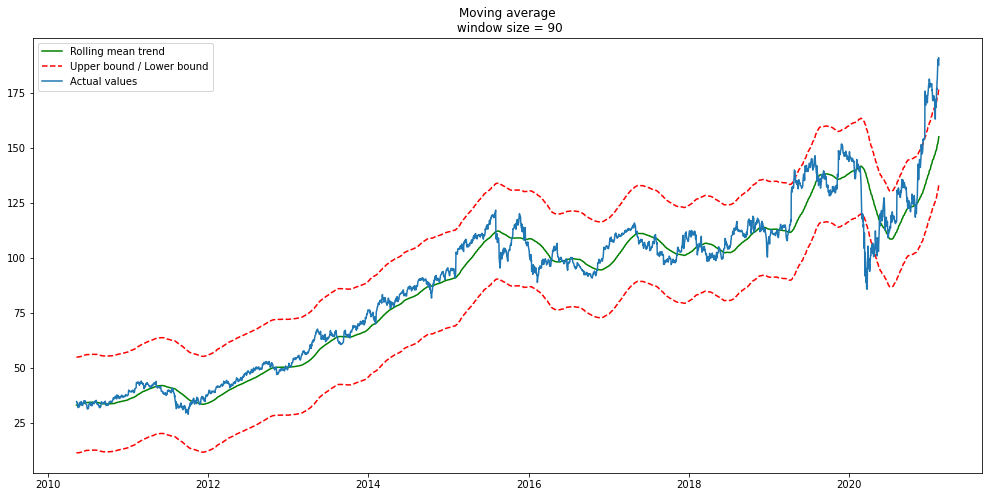

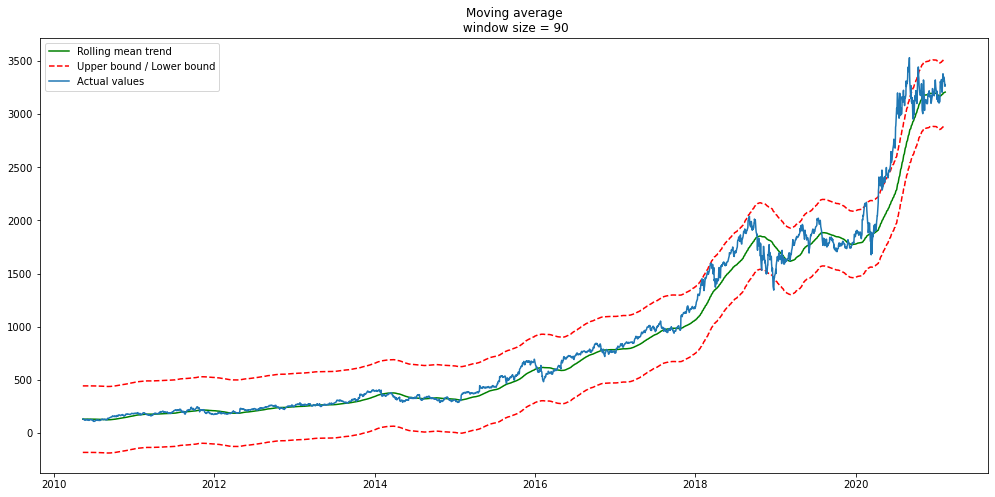

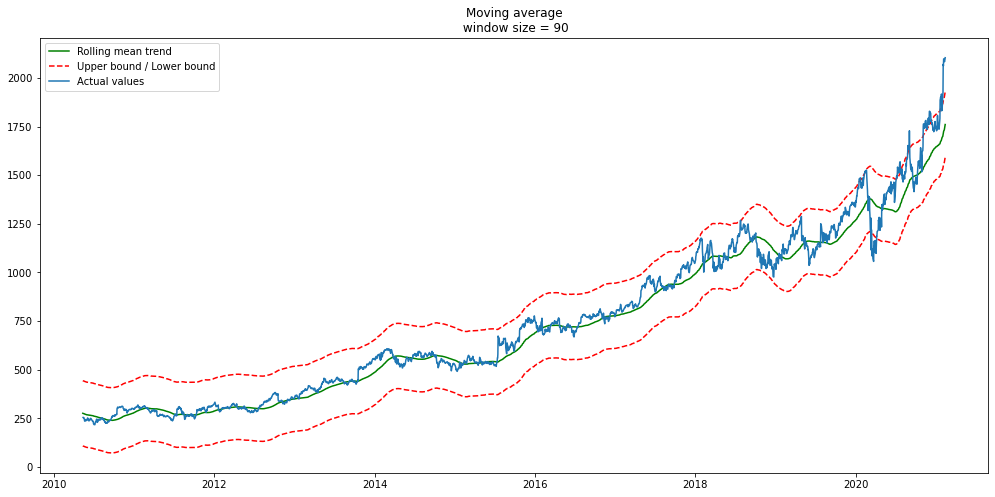

In [68]:
for i in stock:
    plot_moving_average(stocks[i].Close, 90, plot_intervals=True)

In [69]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

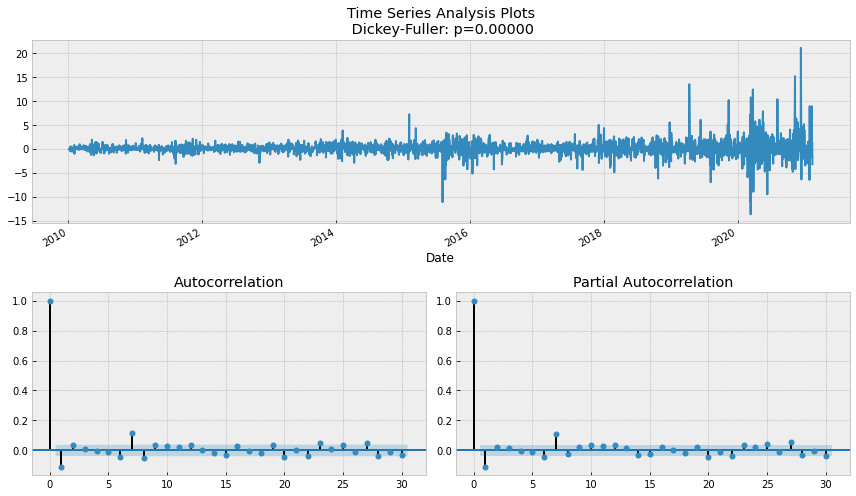

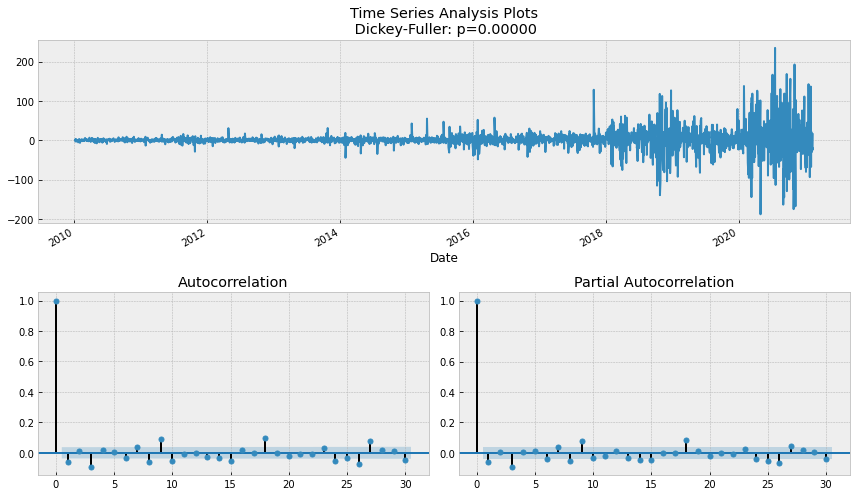

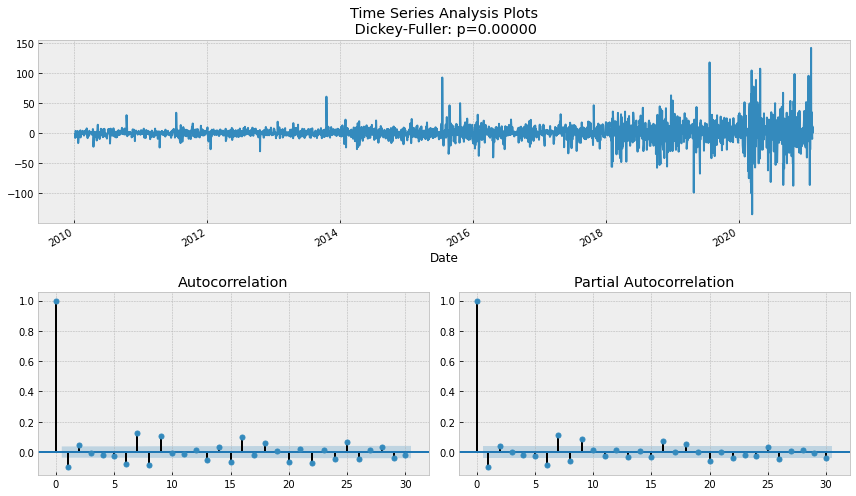

In [70]:
data_diff = {}
for i in stock:
    data_diff[i] = stocks[i].Close - stocks[i].Close.shift(1)
    tsplot(data_diff[i][1:], lags=30) 

In [71]:
stocks_freq = {}
for i in stocks:
    dfreg = stocks[i].loc[:, [ 'Adj Close', 'Volume']]
    dfreg['HighLow_PCT'] = (stocks[i]['High'] - stocks[i]['Low']) / stocks[i]['Close'] * 100.0
    dfreg['PCT_change'] = (stocks[i]['Close'] - stocks[i]['Open']) / stocks[i]['Open'] * 100.0
    stocks_freq[i] = dfreg

Accuracy of DISis 0.7762351110820215
Accuracy of AMZNis 0.9607352942690258
Accuracy of GOOGis 0.9396142741176983


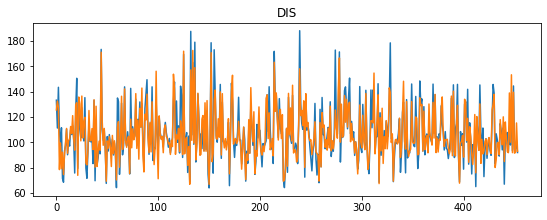

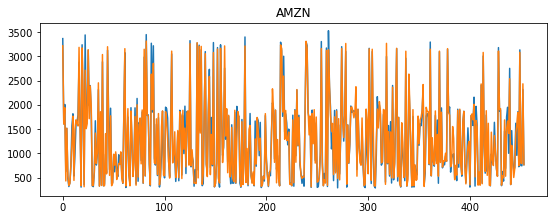

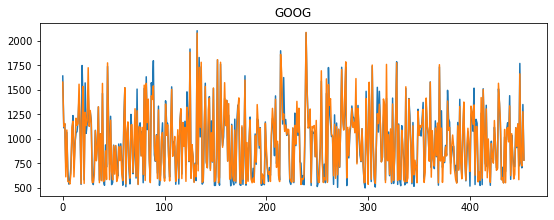

In [79]:
predictions = {}
for i in stocks:
    stocks_freq[i].fillna(value=-99999, inplace=True)
    forecast = int(math.ceil(0.352 * len(dfreg)))
    forecast_col = 'Adj Close'
    stocks_freq[i]['label'] = stocks_freq[i][forecast_col].shift(-forecast)
    X = np.array(stocks_freq[i].drop(['label'], 1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast:]
    X = X[:-forecast]
    y = np.array(stocks_freq[i]['label'])
    y = y[:-forecast]
    rf_model = RandomForestRegressor()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=60)
    rf_model.fit(X_train, y_train)
    score = rf_model.score(X_test, y_test)
    print("Accuracy of " + i + 'is ' + str(score))
    stocks_freq[i].tail(806)
    y_pred = rf_model.predict(X_test)
    predictions[i] = pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
    fig = plt.figure(figsize=(20, 7))
    acf_ax = plt.subplot2grid((2, 2), (0,0))
    acf_ax.set_title(i)
    acf_ax.plot(y_test)
    acf_ax.plot(y_pred)

In [73]:
predictions['DIS']

,0,1
0,123.904331,133.240005
1,133.465518,111.230621
2,129.751421,143.440613
3,78.068612,108.311127
4,100.007143,97.396370
...,...,...
449,138.115694,144.500000
450,91.221802,94.193405
451,91.876273,94.668541
452,118.300854,101.059998


In [74]:
predictions['AMZN']

,0,1
0,3231.620559,3368.000000
1,1598.159188,1607.949951
2,1950.682004,2009.900024
3,441.812898,625.309998
4,1477.531198,1517.859985
...,...,...
449,3088.705933,3135.659912
450,805.025906,750.570007
451,789.238917,745.809998
452,2428.620408,2317.800049


In [75]:
predictions['GOOG']

,0,1
0,1582.843992,1641.839966
1,1134.594321,1113.650024
2,1153.128605,1153.579956
3,604.870660,722.159973
4,1072.460499,1067.449951
...,...,...
449,1655.432825,1770.150024
450,770.673109,758.039978
451,726.455279,705.630005
452,1267.756288,1351.109985
